In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np
from keras.models import load_model
# import pytesseract
import math
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np


def PredictImg(img):
    # 載入模型
    #縮放圖片大小
    Max_Width=20
    Max_Hight=20
    x_test = []
    # for img in imgs:
    try:
        img = cv2.resize(img, (Max_Width, Max_Hight), interpolation=cv2.INTER_CUBIC)
    except:
        return None
    x_test.append(img)
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], Max_Width, Max_Hight, 1)
    x_test = 255 - x_test
    x_test = x_test.astype('float32')
    x_test /= 255
    pred = model.predict(x_test,batch_size = 25)
    outdict = ['0','1','2','3','4','5','6','7','8','9']
    pred_result = outdict[np.argmax(pred)]
    return pred_result

#去除掉圖片的雜訊，使用filter來決定可不可以用
def ImageFilter(width,height):
    # 面積太小就算雜訊
    if width<=5 or width>20 or width*height<70 \
        or width*height>400 or height <= 14 or height > 22 or height - width < 5:
        return False 
    else:
        return True

# 定義旋轉rotate函數
def rotate(image, angle, center=None, scale=1.0):
    # 獲取圖像尺寸
    (h, w) = image.shape[:2]
 
    # 若未指定旋轉中心，則將圖像中心設為旋轉中心
    if center is None:
        center = (w / 2, h / 2)
 
    # 執行旋轉
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
 
    # 返迴旋轉後的圖像
    return rotated

Using TensorFlow backend.


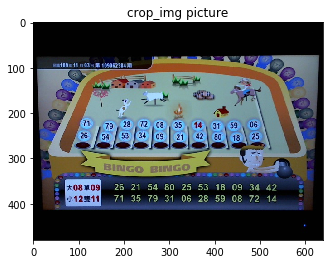

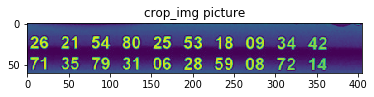

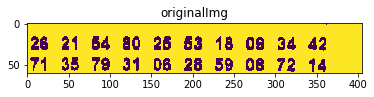

40


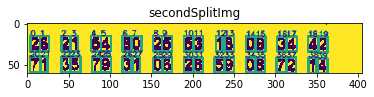

In [2]:

img = Image.open('3_3.jpg')
#二值化限制值
threshValue = 100
plt.imshow(img)
plt.title('crop_img picture')
plt.show()


#x軸（橫向）
#y軸（直向）
#area = (x1,y1,
#        x2,y2)
area =  (175, 340,
        580, 400)
crop_img = img.crop(area)


img = cv2.cvtColor(np.asarray(crop_img),cv2.COLOR_RGB2BGR)  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.title('crop_img picture')
plt.show()

originalImg = img.copy()                              
originalImg = cv2.GaussianBlur(originalImg, (1,1), 1)

#二值化
ret,originalImg = cv2.threshold(originalImg,threshValue,255,        
                                cv2.THRESH_BINARY_INV)
#x軸（橫向）
#y軸（直向）
#膨脹
originalImg = cv2.erode(originalImg, (1,2), iterations = 2)
plt.imshow(originalImg)
plt.title('originalImg')
plt.show()


secondSplitImg = originalImg.copy()
#把完全看不到文字只剩下填滿黑色的色塊版本去做輪廓辨識
secondSplitImg ,Splitcontours,hierarchy = cv2.findContours(secondSplitImg,cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_NONE)


#做Y軸排序
Splitcontours = sorted(Splitcontours, key=lambda ctr: cv2.boundingRect(ctr)[1])

boundle = []
offset = (0,0)
for i in range(0,len(Splitcontours)):  
    x, y, width, height = cv2.boundingRect(Splitcontours[i])  
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
    # print (x, y, width, height)
    #把符合規則的邊界存起來
    boundle.append([x, y, width, height])

print (len(boundle))
#取得前20個共九組數字排序好的界線
boundle_first = sorted(boundle[:20], key=lambda bound: bound[0])

#取得後20個共九組數字排序好的界線
boundle_second = sorted(boundle[20:], key=lambda bound: bound[0])

def DrawBoundle(boundle,img):
    for i in range(0,len(boundle)):  
        x, y, width, height = boundle[i]
        x = x + offset[0]
        y = y + offset[1]
        cv2.rectangle(img, (x, y),
                                    (x + width, 
                                    y + height), (153,153,0), 2) 

    for i in range(0,len(boundle)):  
        x, y, width, height = boundle[i]
        x = x+offset[0]
        y = y+offset[1]
        cv2.putText(img, str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX,
            0.3, (0, 255, 255), 1, cv2.LINE_AA)
    return img
boundle = boundle_first + boundle_second
secondSplitImg = DrawBoundle(boundle,secondSplitImg)
plt.imshow(secondSplitImg)
plt.title("secondSplitImg")
plt.show()

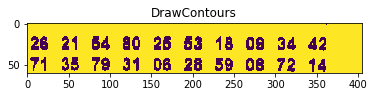

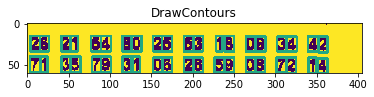

26,21,54,80,25,53,18,06,34,42,71,35,79,31,06,28,59,08,72,14,

In [3]:
model = load_model('Models/model.h5')
#因為進行開閉運算後，邊緣會偏移，所以要有一個Offset 修正 (x,y,width,height)
#x軸（橫向）
#y軸（直向）
offset = (0,0)



DrawContours = originalImg.copy()
plt.imshow(DrawContours)
plt.title("DrawContours")
plt.show()
for i in range(0,len(boundle)):  
    x, y, width, height = boundle[i]
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
    x = x+offset[0]
    y = y+offset[1]
    cv2.rectangle(DrawContours, (x, y),
                                (x + width, 
                                 y + height), (153,153,0), 2) 


plt.imshow(DrawContours)
plt.title("DrawContours")
plt.show()

_originalImg = originalImg.copy()
#儲存所有號碼圖的位置圖
output = []
for i in range(0,len(boundle)):  
    x, y, width, height = boundle[i]
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
    # print (i,",",x, y, width, height)
    #x軸（橫向）
    #y軸（直向）
    x = x+offset[0]
    y = y+offset[1]

    newImage=_originalImg[y:y+height,
                     x:x+width]

    predValue = PredictImg(newImage)
    # plt.imshow(img)
    # plt.title(predValue)
    # plt.show()
    output.append(predValue)

    input_dir=("cut_image/")
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    cv2.imwrite("./cut_image/{i}_{predValue}.jpg".format(i=str(i),predValue = predValue),newImage) 

# output.reverse()

#每兩個數字為一組，這樣比較好區分數組
step = 2
output = [output[i:i+step] for i in range(0,len(output),step)]
for ele in output:
    try:
        print (''.join(ele) + "," , end='')
    except:
        continue

